In [1]:
import numpy as np
import scipy as sp
import sklearn as sk
import pandas as pd
import sklearn.cluster as skcluster
# import seaborn as sns

In [80]:
def init_multi(x, K):
    phi = x[np.random.randint(0, x.shape[0], K)]
    phi = phi/np.sum(phi, axis=1).reshape((-1, 1))
    pi = np.ones(K)/K
    return (pi, phi)

def E_multi(x, theta):
    pi, phi = theta
    N, I = x.shape
    K = pi.size
    w = np.log(phi).dot(x.T)+np.log(pi).reshape((-1,1))
    w = w-sp.misc.logsumexp(w, axis=0)
    w = np.exp(w)
    return w

def M_multi(x, w):
    N = x.shape[0]
    phi = w.dot(x)
    phi = phi/phi.sum(axis=1).reshape((-1, 1))
    pi = np.sum(w, axis=1)
    pi = pi/np.sum(pi)
    return (pi, phi)

def init_normal(x, K):
    clusters = skcluster.KMeans(n_clusters=K)
    clusters.fit(x)
    pi = np.bincount(clusters.predict(data))
    mu = clusters.cluster_centers_    
    pi.resize(K)
    pi = (pi/np.sum(pi))*0.9+(0.1/K)
    return (pi, mu)

def E_normal(x, theta):
    pi, mu = theta
    N, I = x.shape
    K = pi.size
    w = -0.5*(np.ones((K,I)).dot((x*x).T)-2*(mu.dot(x.T))+(mu*mu).dot(np.ones((I,N))))
    w += np.log(pi).reshape((-1,1))
    w -= sp.misc.logsumexp(w, axis=0)
    w = np.exp(w)
    return w

def M_normal(x, w):
    N = x.shape[0]
    pi = np.sum(w, axis=1)
    mu = w.dot(x) / pi.reshape((-1, 1))
    pi = pi/np.sum(pi)
    return (pi, mu)
    
def EM(X, k, Estep, Mstep, Init=None, theta=None, iters=40):
    if not theta:
        theta = Init(X, k)
    for i in range(iters):
        e = Estep(X, theta)
        theta = Mstep(X, e)
    return theta

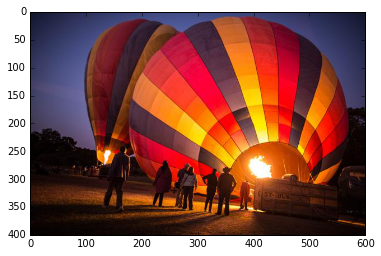

In [6]:
from PIL import Image
from matplotlib.pyplot import imshow, figure
%matplotlib inline

im = Image.open('test_images/balloons.jpg')
imshow(im)
data = np.asarray(im, dtype=np.float64)
H,W,_ = data.shape
dshape = data.shape
data = (data/256).reshape(H*W, 3)

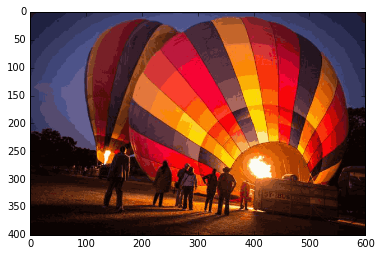

In [24]:
def display(x, theta, shape):
    N,I = x.shape
    pi, mu = theta
    K = pi.size
    w = -0.5*(np.ones((K,I)).dot((x*x).T)-2*(mu.dot(x.T))+(mu*mu).dot(np.ones((I,N))))
    pos = np.argmax(w, axis=0).reshape(N)
    img = np.zeros((N, 3))
    for i in range(K):
        img[pos==i,:] = mu[i]
    figure()
    imshow(img.reshape(dshape))

(pi, mu) = init_normal(data, 50)  
display(data, (pi, mu), dshape)

In [71]:
(pi1, mu1) = EM(data, 50, E_normal, M_normal, theta=(pi, mu), iters=1)

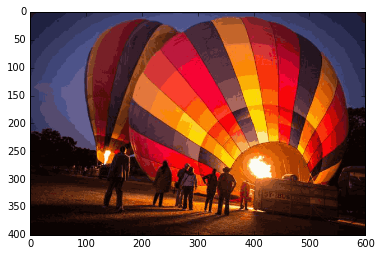

In [72]:
display(data, (pi1, mu), dshape)

In [74]:
def words():
    file = open('data/docword.nips.txt', 'r')
    D,W,NNZ = (int(file.readline().strip()) for i in range(3))
    X = np.zeros([D,W])
    for line in file:
        n,i,w = tuple(map(int, line.strip().split(' ')))
        X[n-1,i-1] = w
    return X

words = words()+1
pi2,phi2 = init_multi(words, 10)

In [111]:
(pi3, phi3) = EM(words, 30, E_multi, M_multi, theta=(pi2, phi2), iters=4)

In [60]:
voca = np.array([line.strip() for line in open('data/vocab.nips.txt')], dtype='|S20')
voca

array([b'a2i', b'aaa', b'aaai', ..., b'zur', b'zurich', b'zwislocki'], 
      dtype='|S20')

In [117]:
def show_topic(colum, n):
    nth = np.partition(-colum,n)[n]
    return sorted(voca[colum>-nth])
def problem3(phi):
    for i in range(phi.shape[0]):
        print(" ".join(map(lambda x: x.decode('utf-8'), show_topic(phi[i], 10))))
problem3(phi2)
print("=======")
problem3(phi3)

cost data early ebd function obd set stopping weight
architecture component distribution information input layer learning network order output
character classes classifier error net neural output recognition training word
compression data energy filter image model mrf number output
algorithm alignment hmm length model protein sequence sequences states
activity diffusion grouping input layer local maxima motion nadel network
committee error network neural output performance signal task training unit
active data learner learning model network neural variance
information input learning neuron point stationary vector weight
camera head input network neural system video
algorithm error function input learning network set training vector weight
component distribution function information input learning model network order output
classifier model network neural recognition set speech system training word
data function information model network neural neuron point signal system
action algorith

In [96]:
nth = np.partition(-phi3[0], 3)[3-1]
print(np.sum())

array([ 0.02763875,  0.01388375,  0.0629975 ,  0.03150125,  0.00996875,
        0.0127325 ,  0.01595   ,  0.00614   ,  0.03151625,  0.01058   ,
        0.01649   ,  0.0090725 ,  0.02594   ,  0.01189625,  0.01325   ,
        0.01671875,  0.0128    ,  0.005495  ,  0.0112325 ,  0.04261625,
        0.01308875,  0.02316875,  0.0159575 ,  0.037295  ,  0.02003375,
        0.01812125,  0.01989875,  0.0215675 ,  0.0141725 ,  0.02597   ,
        0.01413875,  0.013865  ,  0.070445  ,  0.02642   ,  0.0175625 ,
        0.02229125,  0.00619625,  0.0139475 ,  0.01869875,  0.01811   ,
        0.0212975 ,  0.04826   ,  0.00846875,  0.018575  ,  0.01439   ,
        0.004595  ,  0.01944125,  0.01890125,  0.0109175 ,  0.015785  ])